In [1]:
import os
import torch
import random
import numpy as np
import pandas as pd
from torch import nn
import torch.optim as optim
import matplotlib.pyplot as plt
from skimage import io, transform
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader

## Custom Transform, Normalize & ToTensor

In [2]:
class Select_Points(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size

    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            a = np.linalg.norm(verts[faces[i][0]]-verts[faces[i][1]])
            b = np.linalg.norm(verts[faces[i][1]]-verts[faces[i][2]])
            c = np.linalg.norm(verts[faces[i][2]]-verts[faces[i][0]])
            s = 0.5*(a+b+c)
            areas[i] = max(s*(s-a)*(s-b)*(s-c),0)**0.5
            
        sampled_faces = (random.choices(faces, weights=areas, cum_weights=None, k=self.output_size))
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            point1, point2, point3 = (verts[sampled_faces[i][0]],verts[sampled_faces[i][1]], verts[sampled_faces[i][2]])
            s, t = sorted([random.random(), random.random()])
            func = lambda i: s * point1[i] + (t-s)*point2[i] + (1-t)*point3[i]
            sampled_points[i] = (func(0), func(1), func(2))
        return sampled_points
    
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))
        return  norm_pointcloud
    
class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        a = torch.from_numpy(pointcloud)
        return a.type(torch.DoubleTensor)

## Custom DataSet

In [3]:
class ModelNet_Dataset(Dataset):
    def __init__(self, root_dir,  folder=None, transform=None):
        self.transform = transform
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir+"/"+dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.files = []
        for cl in self.classes.keys():
            new_dir = root_dir+"/"+cl+"/"+folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['Obj_Path'] = new_dir+"/"+file
                    sample['Class'] = cl
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):            
        Obj_Path = self.files[idx]['Obj_Path']
        Class = self.files[idx]['Class']
        Datapoint = None
        with open(Obj_Path, 'r') as file:
            off_header = file.readline().strip()
            if 'OFF' == off_header:
                data, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
            else:
                data, n_faces, __  = tuple([int(s) for s in off_header[3:].split(' ')])
            data = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(data)]
            faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
            if self.transform:
                Datapoint = self.transform((data, faces))
        return {
            'Data': Datapoint, 
            'Class': self.classes[Class]
        }

## Model Architecture T.Net 

In [4]:
class T_Net(nn.Module):
    def __init__(self, k=3):
        super(T_Net, self).__init__()
        self.k = k
        self.ConvBlock = nn.Sequential(
            nn.Conv1d(in_channels=k, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(kernel_size=2, stride=2),
            
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(kernel_size=2, stride=2),
            
            nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.FC_Block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16384, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, k*k),
        )
    
    def forward(self, x):
        out = self.ConvBlock(x)
        out = self.FC_Block(out)
        out = out.reshape(-1, self.k, self.k)
        return out

## Model Architecture PointNet

In [5]:
class Point_Net(nn.Module):
    def __init__(self, number_of_classes):
        super(Point_Net, self).__init__()
        self.T_Net3 = T_Net(3)
        self.ConvSet_1 = nn.Sequential(
            nn.Conv1d(in_channels=3, out_channels=32, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(kernel_size=1, stride=1)
        )
        self.T_Net64 = T_Net(64)
        self.ConvSet_2 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Conv1d(in_channels=128, out_channels=128, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Conv1d(in_channels=128, out_channels=1024, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.MaxPool1d(kernel_size=1, stride=1)
        )
        self.FC_Layers = nn.Sequential(
            nn.MaxPool1d(1024),
            nn.Flatten(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, number_of_classes),
        )
        
    def forward(self, x):
        Tnet3 = self.T_Net3(x)
        x = torch.bmm(torch.transpose(x,1,2), Tnet3).transpose(1,2)
        x = self.ConvSet_1(x)
        Tnet64 = self.T_Net64(x)
        x = torch.bmm(torch.transpose(x,1,2), Tnet64).transpose(1,2)
        x = self.ConvSet_2(x)
        x = self.FC_Layers(x)
        return x

In [6]:
tra = transforms.Compose([
    Select_Points(1024),
    Normalize(),
    ToTensor()
])
DataSet_Path = "../input/modelnet10-princeton-3d-object-dataset/ModelNet10"

Train_Dataset = ModelNet_Dataset(DataSet_Path, "train", tra)
Test_Dataset = ModelNet_Dataset(DataSet_Path, "test", tra)

Train_loader = DataLoader(Train_Dataset, shuffle=True, num_workers=2, batch_size=64)
Test_loader = DataLoader(Test_Dataset, shuffle=True, num_workers=2, batch_size=64)

print('Train DataSet len:',len(Train_Dataset))
print('Train DataSet Classes:',len(Train_Dataset.classes))
print('Test DataSet len:',len(Test_Dataset))
print('Test DataSet Classes:',len(Test_Dataset.classes))

Train DataSet len: 3991
Train DataSet Classes: 10
Test DataSet len: 908
Test DataSet Classes: 10


0 Bath-Tub


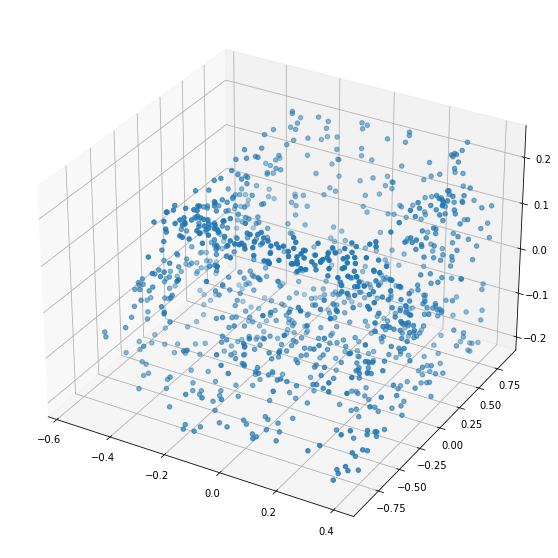

In [7]:
PointCloud = next(iter(Train_Dataset))
print(PointCloud['Class'], 'Bath-Tub')
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(PointCloud['Data'][:, 0], PointCloud['Data'][:, 1], PointCloud['Data'][:, 2])
# ax.set_axis_off()
plt.show()

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Point_Net(len(Train_Dataset.classes))
model.load_state_dict(torch.load("../input/pointnet-trained-weights/PointNet_Model.pt"))
model = model.to(device=device)
print('Device: ',device)

Device:  cuda


In [9]:
learning_rate = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= learning_rate)

In [10]:
num_epochs = 10
for epoch in range(num_epochs):
    loss_ep = 0
    for data in Train_loader:
        images = data['Data'].to(device=device).transpose(1, 2)
        labels = data['Class'].to(device=device) 
        images = images.type(torch.cuda.FloatTensor)
        optimizer.zero_grad()
        scores = model(images)
        loss = criterion(scores, labels)
        loss.backward()
        optimizer.step()
        loss_ep += loss.item()
    print('Epoch [{}/{}] :::: Loss: {:.4f}'.format(epoch+1, num_epochs, loss_ep/len(Train_loader)))
    torch.save(model.state_dict(), "PointNet_Model.pt")

Epoch [1/10] :::: Loss: 0.3018
Epoch [2/10] :::: Loss: 0.2693
Epoch [3/10] :::: Loss: 0.2583
Epoch [4/10] :::: Loss: 0.2455
Epoch [5/10] :::: Loss: 0.2650
Epoch [6/10] :::: Loss: 0.2376
Epoch [7/10] :::: Loss: 0.2231
Epoch [8/10] :::: Loss: 0.2183
Epoch [9/10] :::: Loss: 0.2334
Epoch [10/10] :::: Loss: 0.2196


In [11]:
torch.save(model.state_dict(), "PointNet_Model.pt")

In [12]:
model = Point_Net(len(Train_Dataset.classes))
model.load_state_dict(torch.load("./PointNet_Model.pt"))
model = model.to(device=device)
model.eval()

Point_Net(
  (T_Net3): T_Net(
    (ConvBlock): Sequential(
      (0): Conv1d(3, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): ReLU()
      (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): ReLU()
      (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (8): ReLU()
      (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (11): ReLU()
      (12): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (13): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (14): Conv1d(128, 128, kernel_size=

In [13]:
with torch.no_grad():
    correct = 0
    total = 0
    for data in Test_loader:
        images = data['Data'].to(device=device).transpose(1, 2)
        labels = data['Class'].to(device=device) 
        images = images.type(torch.cuda.FloatTensor)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()           
    print('Accuracy of the Model on the {} Test Images: {}%'.format(len(Test_Dataset), 100*correct /total))

Accuracy of the Model on the 908 Test Images: 87.33480176211454%
